In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
#from scipy import interp, arange, exp
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor
import shutil

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_v9.1_02-01/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_02-01/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [7]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [8]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

In [9]:
dir_image = dir_project+info_basic['dir_image'] + 'K-S_analysis/'
dir_disp_probes  = dir_project_probes + info_basic_probes['dir_disp'] 
dir_partition_probes = dir_project_probes + info_basic_probes['dir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['dir_partition']
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp_probes)
if not os.path.exists(dir_image):
    os.makedirs(dir_image)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_02-01/image_v9.1_02-01/K-S_analysis/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/autopick17-01//


In [10]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [11]:
stations_probes = {}
lat_probes = {}
lon_probes = {}
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)

In [12]:
station_targets = {}
lat_targets = {}
lon_targets = {}
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    station_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)

In [13]:
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])

In [14]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [15]:
ds_probe_all = {}
for probe in info_basic_probes['key_subworks']:
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

### Cluster

In [16]:
phase_mean = info_basic_bi['phase_mean']
ks_f_range = info_basic['ks_f_range']
ks_f_range

[7.5, 13]

In [17]:
def extract_probes(target):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global station_targets

    stas = station_targets[target]
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [18]:
def find_nearest(lon_this,lat_this,lon_stations_all,lat_stations_all):
    lon_stations_all = np.array(lon_stations_all)
    lat_stations_all = np.array(lat_stations_all)
    lon_stations_all = lon_stations_all.reshape(-1,1)
    lat_stations_all = lat_stations_all.reshape(-1,1)
    dist = np.sqrt((lon_stations_all-lon_this)**2+(lat_stations_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    #print(lon_stations_all)
    #print(index)
    return index

In [19]:
def cluster_filter(target):
    global flag_err
    global flag_plot
    global dir_image
    global flag_pass
    global ds_probe_all
    global targets
    global probes
    global lon_stations_all
    global lat_stations_all
    global lon_sta
    global stations_accept_all
    global lon_centroid_all 
    global lat_centroid_all 
    global probe_accept_all
    global probe_ref_all

    # extract all disp
    probes_this = extract_probes(target)
    stations = set()
    lon_centroid_probe = []
    lat_centroid_probe = []
    for probe in probes_this:
        stations_this = stations_probes[probe]
        stations = stations.union(set(stations_this))
        lon_centroid_probe.append(np.mean( lon_probes[probe]))
        lat_centroid_probe.append(np.mean( lat_probes[probe]))
    stations = list(stations)
    lon_stations_this = []
    lat_stations_this = []
    for sta in stations:
        index = stalist_all.index(sta)
        lon_stations_this.append(lon_stations_all[index])
        lat_stations_this.append(lat_stations_all[index])

    # 读取全部autopick dispersion curves
    disp_all = {}
    for probe in probes_this:
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp_all[probe] = disp[index,:]
    phase_this = [phase_mean[probe] for probe in probes_this]

    # find central probe and cluster based on it
    lon_centroid_this = np.mean(lon_stations_this)
    lat_centroid_this = np.mean(lat_stations_this)
    index = find_nearest(lon_centroid_this,lat_centroid_this,lon_centroid_probe,lat_centroid_probe)
    c_ref = phase_this[index]
    probe_ref = probes_this[index]
    
    phase_sort = np.sort(phase_this)
    index_phase = range(len(phase_sort))
    probe_accept = []
    phase_accept = []
    station_accept = set()
    lon_centroid_accept = []
    lat_centroid_accept = []
    for probe in probes_this:
        if phase_mean[probe] >= c_ref*(1-flag_err) and phase_mean[probe] <= c_ref*(1+flag_err):
            probe_accept.append(probe)
            station_accept = station_accept.union(set(stations_probes[probe]))
            lon_centroid_accept.append(np.mean(lon_probes[probe]))
            lat_centroid_accept.append(np.mean(lat_probes[probe]))
            phase_accept.append(phase_mean[probe])
    station_accept = list(station_accept)
    lon_stations_accept = []
    lat_stations_accept = []
    for sta in station_accept:
        index = stalist_all.index(sta)
        lon_stations_accept.append(lon_stations_all[index])
        lat_stations_accept.append(lat_stations_all[index])


    # ks analysis
    index = find_nearest(lon_centroid_this,lat_centroid_this,lon_centroid_accept,lat_centroid_accept)
    probe_ref = probe_accept[index]

    f_sample = np.linspace(ks_f_range[0],ks_f_range[1],200,endpoint=False)
    c_pick = {}
    for probe in probes_this:
        c_pick[probe] = []
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp = disp[index,:]
        f_this = disp[:,0]
        c_this = disp[:,1]
        # 生成插值函数,可以外推
        #f = interpolate.interp1d(f_this,c_this,kind='cubic')
        f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
        c_pick[probe] = f(f_sample)

    f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
    c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
    #f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic')
    f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
    c_pick_ref = f(f_sample)

    ks_p_values = []
    ks_statistic = []
    for probe in probe_accept:
        ks_p_values.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[1])
        ks_statistic.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[0])

    # original partition
    sta_original = set()
    for probe in probes_this:
        sta_original = sta_original.union(stations_probes[probe])
    sta_original = list(sta_original)
    lon_stations_original = []
    lat_stations_original = []
    for sta in sta_original:
        index = stalist_all.index(sta)
        lon_stations_original.append(lon_stations_all[index])
        lat_stations_original.append(lat_stations_all[index])


    index_pass = np.array(ks_statistic)<flag_pass
    probe_pass = np.array(probe_accept)[index_pass]
    lon_centroid_pass = np.array(lon_centroid_accept)[index_pass]
    lat_centroid_pass = np.array(lat_centroid_accept)[index_pass]
    ks_statistic_pass = np.array(ks_statistic)[index_pass]

    # new partition
    sta_pass = set()
    lon_stations_pass = []
    lat_stations_pass = []
    for probe in probe_pass:
        sta_pass = sta_pass.union(stations_probes[probe])
    sta_pass = list(sta_pass)
    for sta in sta_pass:
        index = stalist_all.index(sta)
        lon_stations_pass.append(lon_stations_all[index])
        lat_stations_pass.append(lat_stations_all[index])
    stations_accept_all[target] = sta_pass
    lon_centroid_all[target] = np.mean(lon_stations_pass)
    lat_centroid_all[target] = np.mean(lat_stations_pass)
    

    if flag_plot == 1:
        fig = plt.figure(figsize=(18,15))
        ax = fig.add_subplot(332)
        ax.scatter(index_phase,phase_sort,c='k',s=20)
        ax.axhline(y=c_ref,color='b',ls='--',label='central mean')
        ax.axhline(y=c_ref*(1-flag_err),color='r',ls='--',label='tolerance range')
        ax.axhline(y=c_ref*(1+flag_err),color='r',ls='--')
        ax.set_xlabel('probe index')
        ax.set_ylabel('phase velocity (km/s)')
        ax.legend()

        ax = fig.add_subplot(331)
        ax.scatter(lon_stations_all,lat_stations_all,c='k',s=1)
        im = ax.scatter(lon_centroid_probe,lat_centroid_probe,c=phase_this,s=20,cmap='jet')
        ax.scatter(lon_centroid_this,lat_centroid_this,c='k',s=60,marker='*',label = 'centroid')
        #设置colorbar范围
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()
        """
        print('phase_max: ', max(phase_this))
        print('phase_min: ', min(phase_this))
        print('phase_bar: ', max(phase_this)-min(phase_this))
        print('phase_percent: ', (max(phase_this)-min(phase_this))/np.mean(phase_this)*100, '%')
        """
        ax = fig.add_subplot(333)
        ax.scatter(lon_stations_all,lat_stations_all,c='k',s=1)
        im = ax.scatter(lon_centroid_accept,lat_centroid_accept,c=phase_accept,s=20,cmap='jet')
        ax.scatter(lon_centroid_this,lat_centroid_this,c='k',s=60,marker='*',label = 'centroid')
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution after filter')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()

        ax = fig.add_subplot(334)
        ax.scatter(lon_stations_all,lat_stations_all,c='k',s=1)
        im = ax.scatter(lon_centroid_accept,lat_centroid_accept,c=ks_statistic,s=20,cmap='jet')
        ax.scatter(lon_centroid_this,lat_centroid_this,c='k',s=60,marker='*',label = 'centroid')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        plt.colorbar(im, ax=ax)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution')

        ax = fig.add_subplot(335)
        ax.scatter(lon_stations_all,lat_stations_all,c='k',s=1)
        im = ax.scatter(lon_centroid_pass,lat_centroid_pass,c=ks_statistic_pass,s=20,cmap='jet')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution after filter')
        plt.colorbar(im, ax=ax)

        ax = fig.add_subplot(336)
        ax.scatter(lon_stations_all,lat_stations_all,c='k',s=1)
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        
        ax.scatter(lon_stations_original,lat_stations_original,c = 'g',s=20,label = 'original partitions')
        # 画空心圆
        ax.scatter(lon_stations_pass,lat_stations_pass,c = None,s=30,marker='o',edgecolors='r',label = 'new partitions')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' partition comparison')
        ax.legend()

        ax = fig.add_subplot(325)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" all probes' dispersion curves")
        ax.legend()
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)

        ax = fig.add_subplot(326)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        probe_pass = list(probe_pass)
        for probe in probe_pass:
            if probe_pass.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.',label='picked probes')
            ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" dispersion curves accepted")
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)
        ax.legend()

        plt.tight_layout()
        plt.savefig(dir_image+'K-S_filter_'+target+'.png',dpi=100)
        plt.close()
    print('cluster_filter: ', target + ' finished, '+str(targets.index(target)+1)+'/'+str(len(targets)))
    probe_accept_all[target] = probe_pass
    probe_ref_all[target] = probe_ref

In [20]:
flag_err = 0.05
flag_pass = 0.25
flag_plot = 0
flag_par = 1
nThreads = 40
probe_accept_all = {}
stations_accept_all = {}
lon_centroid_all = {}
lat_centroid_all = {}
probe_ref_all = {}
if flag_par == 1 and flag_plot == 0:
    pool = ThreadPoolExecutor(max_workers = nThreads)
    for target in targets:
        pool.submit(cluster_filter, target)
    pool.shutdown()
else:
    for target in targets:
        cluster_filter(target)

cluster_filter:  07-03 finished, 1/768
cluster_filter:  08-03 finished, 2/768
cluster_filter:  10-03 finished, 4/768
cluster_filter:  11-03 finished, 5/768
cluster_filter:  22-03 finished, 16/768
cluster_filter:  12-03 finished, 6/768
cluster_filter:  27-03 finished, 21/768
cluster_filter:  23-03 finished, 17/768
cluster_filter:  24-03 finished, 18/768
cluster_filter:  14-03 finished, 8/768
cluster_filter:  21-03 finished, 15/768
cluster_filter:  26-03 finished, 20/768
cluster_filter:  34-03 finished, 28/768
cluster_filter:  13-03 finished, 7/768
cluster_filter:  19-03 finished, 13/768
cluster_filter:  33-03 finished, 27/768
cluster_filter:  25-03 finished, 19/768
cluster_filter:  37-03 finished, 31/768
cluster_filter:  35-03 finished, 29/768
cluster_filter:  29-03 finished, 23/768
cluster_filter:  15-03 finished, 9/768
cluster_filter:  30-03 finished, 24/768
cluster_filter:  41-03 finished, 35/768
cluster_filter:  36-03 finished, 30/768
cluster_filter:  39-03 finished, 33/768
cluster_

/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


cluster_filter:  50-05 finished, 140/768
cluster_filter:  47-05 finished, 137/768
cluster_filter:  45-05 finished, 135/768
cluster_filter:  19-06 finished, 157/768
cluster_filter:  18-06 finished, 156/768
cluster_filter:  20-06 finished, 158/768
cluster_filter:  21-06 finished, 159/768
cluster_filter:  49-05 finished, 139/768
cluster_filter:  28-06 finished, 166/768
cluster_filter:  26-06 finished, 164/768
cluster_filter:  27-06 finished, 165/768
cluster_filter:  29-06 finished, 167/768
cluster_filter:  22-06 finished, 160/768
cluster_filter:  25-06 finished, 163/768
cluster_filter:  07-07 finished, 193/768
cluster_filter:  24-06 finished, 162/768
cluster_filter:  23-06 finished, 161/768
cluster_filter:  37-06 finished, 175/768
cluster_filter:  31-06 finished, 169/768
cluster_filter:  35-06 finished, 173/768
cluster_filter:  33-06 finished, 171/768
cluster_filter:  30-06 finished, 168/768
cluster_filter:  36-06 finished, 174/768
cluster_filter:  08-07 finished, 194/768
cluster_filter: 

In [21]:
info_basic['flag_err'] = flag_err
info_basic['flag_pass'] = flag_pass

### Analyze clusters and reunion

In [22]:
# delete void sets
key_dels = []
for target in targets:
    if len(probe_accept_all[target]) < 3:
        print('delete: ', target)
        del stations_accept_all[target]
        del lon_centroid_all[target]
        del lat_centroid_all[target]
        key_dels.append(target)
for key_del in key_dels:
    targets.remove(key_del)


delete:  44-04
delete:  07-05
delete:  20-05
delete:  30-05
delete:  31-05
delete:  38-05
delete:  43-05
delete:  45-05
delete:  46-05
delete:  50-05
delete:  50-06
delete:  51-06
delete:  07-07
delete:  08-07
delete:  09-07
delete:  29-07
delete:  46-09
delete:  45-11
delete:  46-11
delete:  47-11
delete:  48-11
delete:  45-12
delete:  14-15
delete:  15-15
delete:  21-15
delete:  32-15
delete:  34-15
delete:  40-15
delete:  30-16
delete:  31-17
delete:  32-17
delete:  34-17
delete:  44-17
delete:  22-18
delete:  23-18
delete:  31-18
delete:  32-18
delete:  34-18


In [23]:
def check_lat_lon(target):
    global stations_accept_all_new
    global lon_centroid_all_new
    global lat_centroid_all_new
    global stations_accept_all
    global lon_centroid_all
    global lat_centroid_all
    global flag_subwork

    for key in stations_accept_all_new.keys():
        lon_centroid = lon_centroid_all_new[key]
        lat_centroid = lat_centroid_all_new[key]
        lon = lon_centroid_all[target]
        lat = lat_centroid_all[target]
        if lon_centroid == lon and lat_centroid == lat:
            print(target + ' merge into ' + str(key))
            stations_accept_all_new[key].union(set(stations_accept_all[target]))
            return

    flag_subwork += 1
    new_subwork =  str(flag_subwork)+ '--' + target
    stations_accept_all_new[new_subwork] = set(stations_accept_all[target])
    lon_centroid_all_new[new_subwork] = lon_centroid_all[target]
    lat_centroid_all_new[new_subwork] = lat_centroid_all[target]

In [24]:
stations_accept_all_new = {}
lon_centroid_all_new = {}
lat_centroid_all_new = {}
flag_subwork = 0
for target in targets:
    check_lat_lon(target)
key_subworks_new = stations_accept_all_new.keys()

17-03 merge into 10--16-03
45-03 merge into 37--44-03
15-04 merge into 54--14-04
27-04 merge into 20--27-03
35-04 merge into 28--35-03
37-04 merge into 30--37-03
39-04 merge into 32--39-03
51-04 merge into 43--51-03
52-04 merge into 44--52-03
53-04 merge into 45--53-03
09-05 merge into 86--08-05
11-05 merge into 87--10-05
15-05 merge into 90--14-05
18-05 merge into 92--17-05
23-05 merge into 95--22-05
09-06 merge into 121--08-06
15-06 merge into 126--14-06
53-06 merge into 161--52-06
11-07 merge into 163--10-07
15-07 merge into 166--14-07
53-07 merge into 202--52-07
09-08 merge into 205--08-08
11-08 merge into 206--10-08
13-08 merge into 207--12-08
15-08 merge into 208--14-08
33-08 merge into 225--32-08
45-08 merge into 236--44-08
46-08 merge into 236--44-08
20-09 merge into 257--19-09
29-09 merge into 265--28-09
52-09 merge into 286--51-09
09-10 merge into 290--08-10
11-10 merge into 291--10-10
52-10 merge into 331--51-10
09-11 merge into 335--08-11
11-11 merge into 336--10-11
18-11 m

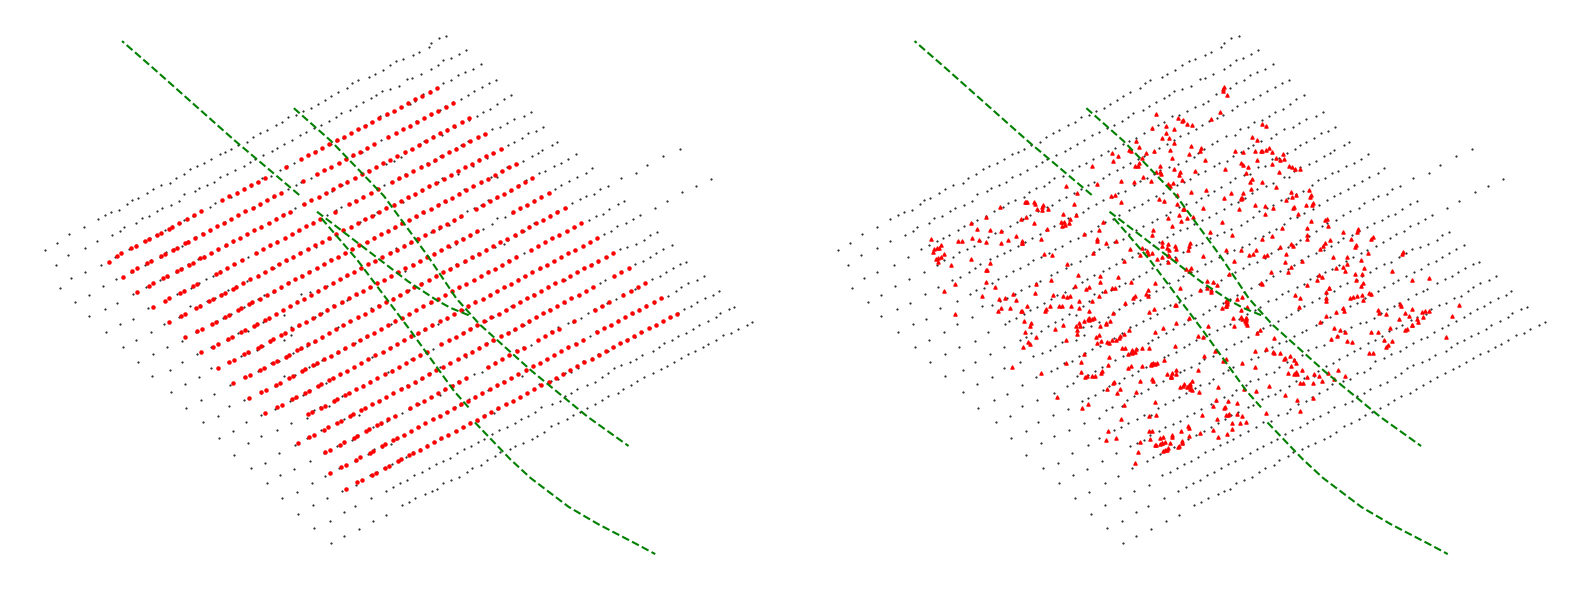

In [25]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=1)
lon_centroid_target = []
lat_centroid_target = []
for target in info_basic_targets['key_subworks']:
    lon_centroid_target.append(np.mean(lon_targets[target]))
    lat_centroid_target.append(np.mean(lat_targets[target]))
ax.scatter(lon_centroid_target,lat_centroid_target,c='r',marker='.',s=20)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
ax.axis('off')
    
ax = fig.add_subplot(122)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
ax.scatter(lon_centroid_all_new.values(),lat_centroid_all_new.values(),c='r',marker='^',s=5)
ax.axis('off')
plt.tight_layout()
plt.savefig(dir_image + 'station_distribution.png')

In [26]:
key_probe = {}
key_probe_accept = {}
for key_subwork in key_subworks_new:
    key_target = key_subwork[key_subwork.find('--')+2:]
    probes_this = extract_probes(key_target)
    key_probe[key_subwork] = probes_this
    key_probe_accept[key_subwork] = probe_accept_all[key_target]
info_basic_bi['probe'] = key_probe
info_basic_bi['probe_accept'] = key_probe_accept

### Save to new subworks

In [27]:
dir_partition = dir_project + 'partition/'
info_basic['dir_partition'] = 'partition/'
if os.path.exists(dir_partition):
    shutil.rmtree(dir_partition)
os.makedirs(dir_partition)

In [28]:
for key_subwork in stations_accept_all_new.keys():
    Station = list(stations_accept_all_new[key_subwork])
    lat = [lat_stations_all[stalist_all.index(station)] for station in stations_accept_all_new[key_subwork]]
    lon =  [lon_stations_all[stalist_all.index(station)] for station in stations_accept_all_new[key_subwork]]
    filename = dir_partition + key_subwork + '.txt'
    np.savetxt(filename, np.array([Station, lat, lon]).T, fmt='%s', delimiter=' ', header='Station lat lon')

In [29]:
info_basic['key_subworks'] = list(stations_accept_all_new.keys())
info_basic['stalistname_all'] = info_basic_probes['stalistname_all']
info_basic['stalistname'] = 'stations_info.xlsx'
info_basic_bi['probe_accept'] = probe_accept_all
info_basic_bi['probe_ref'] = probe_ref_all

In [30]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + 'Basic_info.npy', info_basic_bi)